In [1]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import  Dense,Dropout,Input
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import KFold

2025-06-05 14:00:30.685038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
params=pd.read_fwf('latin_hypercube_params.txt')
#!unzip -qq latin_hypercube_nwLH.zip

In [3]:
params.rename(columns={"# Omega_m": "Omega_m"},inplace=True)

In [4]:
#DataFrame with the cosmological parameters of the simulations
params

,Omega_m,Omega_b,h,n_s,sigma_8,M_nu,w
0,0.2137,0.05715,0.6499,0.8365,0.9489,0.213693,-1.08325
1,0.4281,0.04973,0.7191,1.1063,0.6489,0.949758,-0.94375
2,0.3399,0.05495,0.7463,1.1263,0.9823,0.721067,-1.17955
3,0.2795,0.03025,0.8807,1.0819,0.7275,0.751757,-1.06255
4,0.4505,0.05241,0.6489,0.9415,0.8545,0.250323,-0.87325
...,...,...,...,...,...,...,...
1995,0.3205,0.04161,0.5193,1.0817,0.6649,0.377043,-0.96145
1996,0.1693,0.04009,0.7745,1.0985,0.7457,0.420602,-1.02355
1997,0.4853,0.03785,0.6403,0.8503,0.7771,0.669092,-1.08265
1998,0.2607,0.04169,0.6861,0.8983,0.9689,0.291407,-0.85105


In [5]:
#Normalise the data
params['Omega_m'] =(params['Omega_m']-0.1)/(0.5-0.1)
params['Omega_b'] =(params['Omega_b']-0.03)/(0.07-0.03)
params['h']       =(params['h']-0.5)/(0.9-0.5)
params['n_s']     =(params['n_s']-0.8)/(1.2-0.8)

params['sigma_8'] =(params['sigma_8']-0.6)/(1-0.6)
params['M_nu']    =(params['M_nu']-0.01)/(1-0.01)
params['w']       =(params['w']+1.3)/(-0.7+1.3)

In [6]:
# Choose the min and max values of k for training
imin=1;imax=286;

In [7]:
# Read the data files
psa=[]
for i in range(2000):
    df=pd.read_fwf('latin_hypercube_nwLH/'+str(i)+'/Pk_m_z=0.txt',header=None)
    psa.append(df.iloc[imin:imax,1].values)
ps=np.array(psa)

Text(0, 0.5, 'P(k)')

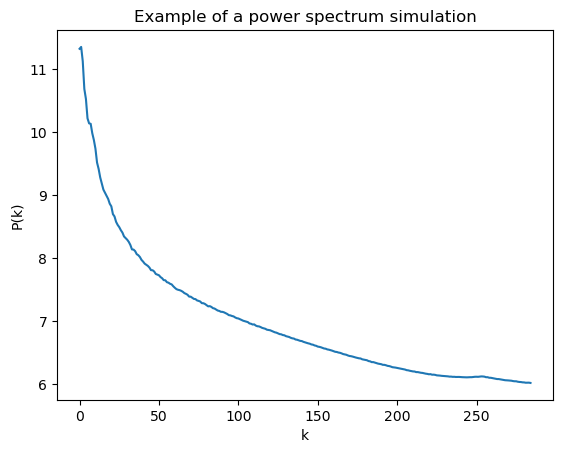

In [8]:
# Power specturm example
df=pd.read_fwf('latin_hypercube_nwLH/0/Pk_m_z=0.txt',header=None)
kvals=df.iloc[imin:imax,0].values
y1=df.iloc[imin:imax,1]
y2=np.log(df.iloc[imin:imax,1].values)
plt.plot(y2)
plt.title('Example of a power spectrum simulation')
plt.xlabel('k')
plt.ylabel('P(k)')

In [9]:
# Neural Networks

In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(params, np.log(ps), test_size=0.05, random_state=66)

In [21]:
# Set up K-Fold Cross-Validation for training the neural networks
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [22]:
def model_NN():
    tf.random.set_seed(87)
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(7,)))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(285, activation='linear'))

    model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['mse']
             )

    return model

In [23]:
def model_NN_PCA():
    modelPCA = tf.keras.models.Sequential()
    modelPCA.add(Input(shape=(7,)))
    modelPCA.add(Dense(2048, activation='relu'))
    modelPCA.add(Dropout(0.6))
    modelPCA.add(Dense(2048, activation='relu'))
    modelPCA.add(Dropout(0.6))
    modelPCA.add(Dense(11, activation='linear'))

    modelPCA.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['mse'])

    return modelPCA

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=125, restore_best_weights=True)

In [25]:
y_pred_NN_all=np.zeros((5,100,285))
y_pred_NN_PCA_all=np.zeros((5,100,285))

#val_mse_per_fold = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold + 1}')

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = np.array(X_train)[train_index], np.array(X_train)[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    #PCA
    pca = PCA(n_components=11)
    y_train_pca_fold  = pca.fit_transform(y_train_fold)
    y_val_pca_fold    = pca.transform(y_val_fold)
    y_test_pca_fold   = pca.transform(y_test)

    # Create a new instance of the model for each fold
    model = model_NN()
    modelPCA = model_NN_PCA()

    print('Neural network')

    # Train the model on the training fold
    model.fit(X_train_fold,y_train_fold, validation_data=(X_val_fold, y_val_fold) ,epochs=3000, callbacks=[early_stopping],verbose=0)
    # Evaluate the model on the validation fold
    y_pred_NN_all[fold]=model.predict(X_test)

    print('Neural network (PCA)')
    # Train the model on the training fold

    modelPCA.fit(X_train_fold,y_train_pca_fold, validation_data=(X_val_fold, y_val_pca_fold) ,epochs=3000, callbacks=[early_stopping],verbose=0)
    # Evaluate the model on the validation fold
    predsPCA_NN=modelPCA.predict(X_test)
    y_pred_NN_PCA_all[fold]=pca.inverse_transform(predsPCA_NN)



Fold 1
Neural network
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Neural network (PCA)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Fold 2
Neural network


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural network (PCA)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Fold 3
Neural network
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Neural network (PCA)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Fold 4
Neural network
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Neural network (PCA)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fold 5
Neural network
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural network (PCA)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [26]:
# Average between folds
y_pred_NN=np.mean(y_pred_NN_all,axis=0)
y_pred_NN_PCA=np.mean(y_pred_NN_PCA_all,axis=0)

In [11]:
# CatBoost
model_CB = CatBoostRegressor(loss_function='MultiRMSE',iterations=5000,verbose=0)
model_CB.fit(X_train, y_train)
y_pred_CB = model_CB.predict(X_test)

In [19]:
# CatBoost PCA
pca = PCA(n_components=11)
y_train_pca_cb  = pca.fit_transform(y_train)


model_CB_PCA = CatBoostRegressor(loss_function='MultiRMSE',iterations=5000,verbose=0)
model_CB_PCA.fit(X_train, y_train_pca_cb)
preds_CB_PCA = model_CB_PCA.predict(X_test)
y_pred_CB_PCA = pca.inverse_transform(preds_CB_PCA)

In [20]:
model_CB_PCA.get_all_params()



{'nan_mode': 'Min',
 'eval_metric': 'MultiRMSE',
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiRMSE',
 '

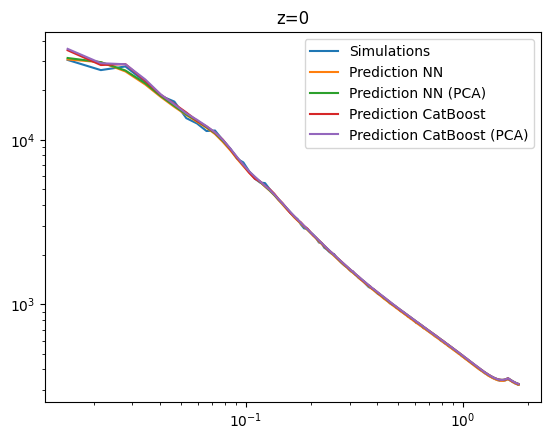

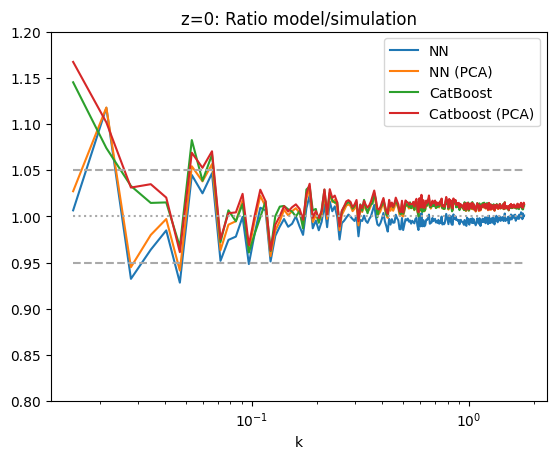

In [29]:
# Example plot on test set
v=3
plt.loglog(kvals,np.exp(y_test[v]),label='Simulations')
plt.loglog(kvals,np.exp(y_pred_NN[v]),label='Prediction NN')
plt.loglog(kvals,np.exp(y_pred_NN_PCA[v]),label='Prediction NN (PCA)')
plt.loglog(kvals,np.exp(y_pred_CB[v]),label='Prediction CatBoost')
plt.loglog(kvals,np.exp(y_pred_CB_PCA[v]),label='Prediction CatBoost (PCA)')

plt.title('z=0')
plt.legend()
plt.show()


plt.figure()
plt.semilogx(kvals,np.exp(y_pred_NN[v])/np.exp(y_test[v]),label='NN')
plt.semilogx(kvals,np.exp(y_pred_NN_PCA[v])/np.exp(y_test[v]),label='NN (PCA)')
plt.semilogx(kvals,np.exp(y_pred_CB[v])/np.exp(y_test[v]),label='CatBoost')
plt.semilogx(kvals,np.exp(y_pred_CB_PCA[v])/np.exp(y_test[v]),label='Catboost (PCA)')


plt.semilogx(kvals,0.95*np.array([1 for i in range(len(kvals))]),'darkgrey',linestyle='--')
plt.semilogx(kvals,1.00*np.array([1 for i in range(len(kvals))]),'darkgrey',linestyle=':')
plt.semilogx(kvals,1.05*np.array([1 for i in range(len(kvals))]),'darkgrey',linestyle='--')
ax = plt.gca()
ax.set_ylim([0.8, 1.2])
plt.xlabel('k')
plt.title('z=0: Ratio model/simulation')
plt.legend()
plt.show()

In [30]:
# Overall RMSE
print('Neural network:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_NN))))
print('Neural Network PCA:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_NN_PCA))))
print('CatBoost:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_CB))))
print('CatBoost PCA:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_CB_PCA))))

Neural network: 4.308122e+02
Neural Network PCA: 3.584239e+02
CatBoost: 5.559218e+02
CatBoost PCA: 5.821802e+02


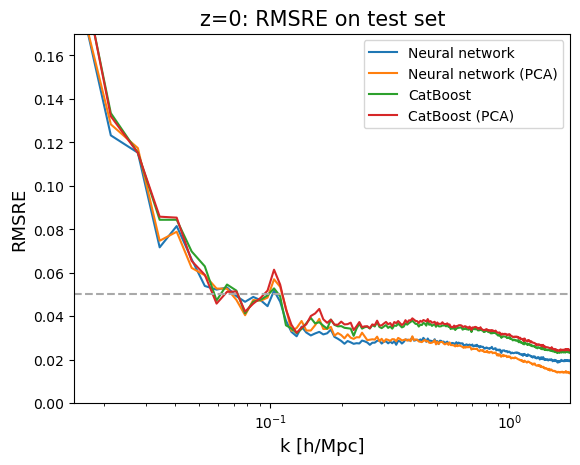

In [43]:
rmse_NN=root_mean_squared_error((np.exp(y_pred_NN)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_NN_PCA=root_mean_squared_error((np.exp(y_pred_NN_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_CB=root_mean_squared_error((np.exp(y_pred_CB)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_CB_PCA=root_mean_squared_error((np.exp(y_pred_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')


plt.semilogx(kvals,rmse_NN,label='Neural network')
plt.semilogx(kvals,rmse_NN_PCA,label='Neural network (PCA)')
plt.semilogx(kvals,rmse_CB,label='CatBoost')
plt.semilogx(kvals,rmse_CB_PCA,label='CatBoost (PCA)')


plt.semilogx(kvals,0.05*np.ones(len(kvals)),'darkgrey',linestyle='--')
#plt.semilogx(kvals,0.03*np.ones(len(kvals)),'darkgrey',linestyle='--')
plt.legend()
plt.xlabel('k [h/Mpc]',fontsize=13)
plt.ylabel('RMSRE',fontsize=13)
plt.title('z=0: RMSRE on test set',fontsize=15)

plt.xlim((kvals[0],kvals[-1]))
plt.ylim((0,0.17))
plt.show()

In [32]:
rmse_output=pd.DataFrame((kvals,rmse_NN,rmse_NN_PCA,rmse_CB,rmse_CB_PCA)).T
rmse_output.columns = ['k', 'Neural network', 'Neural network (PCA)', 'CatBoost','CatBoost (PCA)']
rmse_output.to_csv('rmse_z_0.csv', index=False)

import pickle

data=[y_test, y_pred_NN, y_pred_NN_PCA, y_pred_CB, y_pred_CB_PCA]
# Saving the objects:
#with open('mat.pkl', 'wb') as outfile:
with open('vars_z_0.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [15]:
loaded_data = np.load('data/arrays_z_0.npz')


In [18]:
[y_test, y_pred_NN, y_pred_NN_PCA, y_pred_CB, y_pred_CB_PCA]=[loaded_data['arr_0'],loaded_data['arr_1'],loaded_data['arr_2'],loaded_data['arr_3'],loaded_data['arr_4']]

In [22]:
cb_params = {
    'iterations': [100, 500, 1000, 2000, 5000],
    'l2_leaf_reg': [1,3,5],
    'max_leaves': [32,64,128],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.005, 0.01, 0.05, 0.1]
    }

In [24]:
from sklearn.model_selection import RandomizedSearchCV

pca = PCA(n_components=11)
y_train_pca_cb  = pca.fit_transform(y_train)



random_cv_CB_PCA = RandomizedSearchCV(estimator=CatBoostRegressor(loss_function='MultiRMSE',verbose=0),
            param_distributions=cb_params,
            cv=5, n_iter=40,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 5,
            return_train_score = True,
            random_state=42)

random_cv_CB_PCA.fit(X_train,y_train_pca_cb)

preds_cv_CB_PCA = random_cv_CB_PCA.predict(X_test)
y_pred_cv_CB_PCA = pca.inverse_transform(preds_cv_CB_PCA)

#print('CatBoost PCA:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_CB_PCA))))
print('CatBoost PCA CV:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_cv_CB_PCA))))

random_cv_CB_PCA.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END iterations=5000, l2_leaf_reg=5, learning_rate=0.01, max_depth=9, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END iterations=100, l2_leaf_reg=5, learning_rate=0.01, max_depth=6, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END iterations=5000, l2_leaf_reg=3, learning_rate=0.005, max_depth=3, max_leaves=64;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END iterations=5000, l2_leaf_reg=3, learning_rate=0.005, max_depth=3, max_leaves=64;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END iterations=1000, l2_leaf_reg=5, learning_rate=0.01, max_depth=3, max_leaves=32;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END iterations=2000, l2_leaf_reg=5, learning_rate=0.05, max_depth=6, max_leaves=64;, score=(train=-0.030, test=-0.111) total time= 1.5min
[CV 4/5] END iterations=100, l2_leaf_reg=5, learning_rate=0.005, max_depth=3, max_l

/Users/andreilazanu/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreilazanu/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreilazanu/miniconda3/lib/python3.10/site-packages/catboost/core.py", line 5807, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/Users/andreilazanu/miniconda

[CV 5/5] END iterations=100, l2_leaf_reg=5, learning_rate=0.005, max_depth=3, max_leaves=64;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END iterations=5000, l2_leaf_reg=3, learning_rate=0.05, max_depth=9, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END iterations=5000, l2_leaf_reg=3, learning_rate=0.05, max_depth=9, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END iterations=5000, l2_leaf_reg=3, learning_rate=0.05, max_depth=9, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END iterations=100, l2_leaf_reg=5, learning_rate=0.1, max_depth=3, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END iterations=5000, l2_leaf_reg=5, learning_rate=0.05, max_depth=6, max_leaves=64;, score=(train=-0.009, test=-0.096) total time= 2.3min
[CV 2/5] END iterations=5000, l2_leaf_reg=5, learning_rate=0.05, max_depth=6, max_leaves=64;, score=(train=-0.009, test=-0.112) total time=  41.3s

[CV 2/5] END iterations=1000, l2_leaf_reg=1, learning_rate=0.01, max_depth=6, max_leaves=64;, score=(train=-0.079, test=-0.119) total time=  51.5s
[CV 3/5] END iterations=1000, l2_leaf_reg=1, learning_rate=0.1, max_depth=3, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END iterations=1000, l2_leaf_reg=1, learning_rate=0.01, max_depth=6, max_leaves=64;, score=(train=-0.080, test=-0.110) total time=  50.9s
[CV 3/5] END iterations=1000, l2_leaf_reg=5, learning_rate=0.01, max_depth=3, max_leaves=64;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END iterations=1000, l2_leaf_reg=5, learning_rate=0.01, max_depth=3, max_leaves=64;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END iterations=500, l2_leaf_reg=3, learning_rate=0.05, max_depth=6, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END iterations=500, l2_leaf_reg=3, learning_rate=0.05, max_depth=6, max_leaves=128;, score=(train=nan, test=nan) total time=   0.0s
[

In [25]:
print('CatBoost PCA CV:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_cv_CB_PCA))))

random_cv_CB_PCA.best_estimator_

CatBoost PCA CV: 6.496238e+02


In [26]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

In [27]:
pca = PCA(n_components=11)
y_train_pca_rf  = pca.fit_transform(y_train)
y_test_pca_rf  = pca.fit_transform(y_test)


regr_rf = RandomForestRegressor(n_estimators=5000, verbose=0)
regr_rf.fit(X_train, y_train_pca_rf)
preds_RF_pca=regr_rf.predict(X_test)
y_pred_RF_PCA = pca.inverse_transform(preds_RF_pca)


In [31]:
from sklearn.multioutput import MultiOutputRegressor

regr_lgbm = MultiOutputRegressor(LGBMRegressor(n_estimators=5000,verbose=0))
regr_lgbm.fit(X_train, y_train_pca_rf)
preds_lgbm_pca=regr_lgbm.predict(X_test)
y_pred_lgbm_PCA = pca.inverse_transform(preds_lgbm_pca)


In [29]:
regr_xgb = xg.XGBRegressor(n_estimators=5000)
regr_xgb.fit(X_train, y_train_pca_rf)
preds_xgb_pca=regr_xgb.predict(X_test)
y_pred_xgb_PCA = pca.inverse_transform(preds_xgb_pca)




In [32]:
np.savez('arrays_z_0_all.npz', y_test=y_test, y_pred_NN=y_pred_NN, y_pred_NN_PCA=y_pred_NN_PCA, y_pred_CB=y_pred_CB, y_pred_CB_PCA=y_pred_CB_PCA,y_pred_cv_CB_PCA=y_pred_cv_CB_PCA,y_pred_RF_PCA=y_pred_RF_PCA,y_pred_lgbm_PCA=y_pred_lgbm_PCA,y_pred_xgb_PCA=y_pred_xgb_PCA)

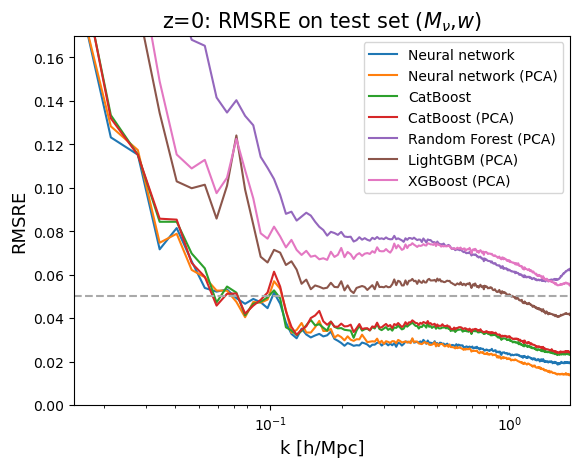

In [50]:
rmse_NN=root_mean_squared_error((np.exp(y_pred_NN)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_NN_PCA=root_mean_squared_error((np.exp(y_pred_NN_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_CB=root_mean_squared_error((np.exp(y_pred_CB)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_CB_PCA=root_mean_squared_error((np.exp(y_pred_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_cv_CB_PCA=root_mean_squared_error((np.exp(y_pred_cv_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_RF_PCA=root_mean_squared_error((np.exp(y_pred_RF_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_lgbm_PCA=root_mean_squared_error((np.exp(y_pred_lgbm_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_xgb_PCA=root_mean_squared_error((np.exp(y_pred_xgb_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')


plt.semilogx(kvals,rmse_NN,label='Neural network')
plt.semilogx(kvals,rmse_NN_PCA,label='Neural network (PCA)')
plt.semilogx(kvals,rmse_CB,label='CatBoost')
plt.semilogx(kvals,rmse_CB_PCA,label='CatBoost (PCA)')
#plt.semilogx(kvals,rmse_cv_CB_PCA,label='CatBoost (PCA) CV')
plt.semilogx(kvals,rmse_RF_PCA,label='Random Forest (PCA)')
plt.semilogx(kvals,rmse_lgbm_PCA,label='LightGBM (PCA)')
plt.semilogx(kvals,rmse_xgb_PCA,label='XGBoost (PCA)')






plt.semilogx(kvals,0.05*np.ones(len(kvals)),'darkgrey',linestyle='--')
plt.legend()
plt.xlabel('k [h/Mpc]',fontsize=13)
plt.ylabel('RMSRE',fontsize=13)
plt.title(r'z=0: RMSRE on test set ($M_{\nu}$,$w$)',fontsize=15)

plt.xlim((kvals[0],kvals[-1]))
plt.ylim((0,0.17))
plt.savefig('mnu_z0_comp.pdf')
plt.show()

In [26]:
import numpy as np

In [33]:
random_cv_CB_PCA.best_estimator_

In [35]:
random_cv_CB_PCA.best_params_

{'n_estimators': 2000, 'max_depth': 6, 'learning_rate': 0.01}

In [13]:
model_CB.feature_importances_
feature_importance = model_CB.get_feature_importance()
feature_names = X.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

array([23.83148052,  8.98326474,  3.04376174,  2.56527146, 59.3326036 ,
        1.46036091,  0.78325703])

In [21]:
feature_importance=model_CB.get_feature_importance()
feature_names = X_train.columns

/var/folders/sq/k44vf0b95wqgf86fst300mzh0000gn/T/ipykernel_1265/3885094006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, palette='rocket')


Text(0, 0.5, 'Features')

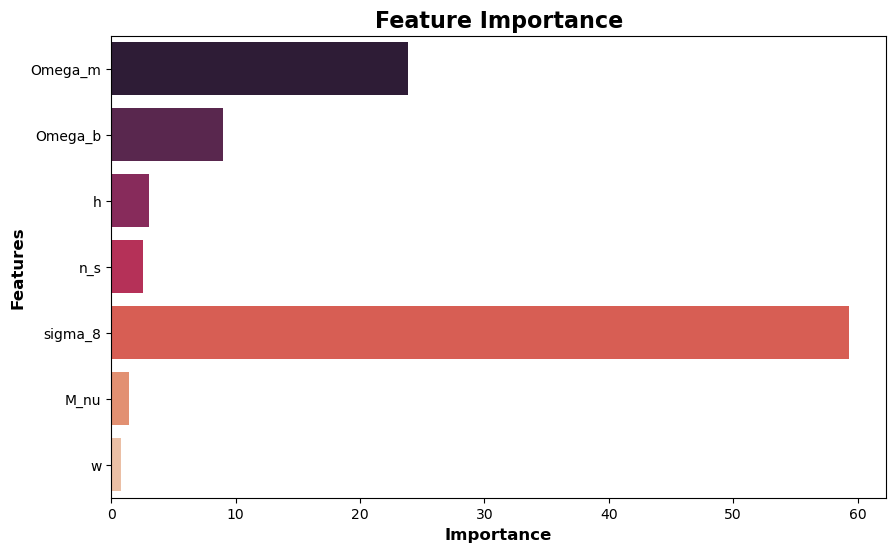

In [22]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names, palette='rocket')
plt.title('Feature Importance', fontweight='bold', fontsize=16)
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.ylabel('Features', fontweight='bold', fontsize=12)